<div align="center">
    <div><img src="../assets/redis_logo.svg" style="width: 130px"> </div>
    <div style="display: inline-block; text-align: center; margin-bottom: 10px;">
        <span style="font-size: 36px;"><b>Multi-document RAG based on LangGraph with Query Understanding and Redis Retrieval Agents</b></span>
        <br />
    </div>
    <br />
</div>



In [Notebook 06](06-multi-document-langgraph_react_agentic_RAG.ipynb), we explored the **ReAct agent** approach to Retrieval-Augmented Generation (RAG). While it may be suitable for planning in uncertain situations, such as robotics where problem parameters are unknown, it may not be ideal for search applications where tasks and steps are well-defined.

In this notebook, we will pivot to a different approach and use **LangGraph** to construct a more deterministic agent that performs the key steps in the search process to answer a user's question. 

### Key Steps in the Search Process

1. **Understanding the Query**: Every search begins with a user query. The primary challenge is understanding the user's intent, which may require personalized and contextual comprehension.
2. **Query Expansion**: This involves refining the query, translating it into the target query language, and mapping it into a vector space using an embedding model.
3. **Retrieving Relevant Documents**: Once the query is represented in the vector space, the next step is to fetch the most relevant documents.
4. **Grading Documents**: After retrieving documents, an LLM is used to grade and score documents based on relevancy.

### Approach for This Notebook

We will cover each of these steps in detail, demonstrating how to construct an agent using LangGraph to execute them effectively. This agent will be designed to understand user queries, perform query expansion, retrieve relevant documents, and rerank the results to provide accurate and contextually relevant answers to the user's questions.

![Graph](query_understanding_graph.png)

## Environment Setup

In [1]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import os
import warnings
import dotenv

warnings.filterwarnings('ignore')

# load env vars from .env file
dotenv.load_dotenv()

False

In [15]:
# set working directory
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
sys.path.insert(0, f'{parent_directory}/helpers')
os.environ["ROOT_DIR"] = parent_directory


REDIS_URL = "redis://localhost:6379"#os.getenv("REDIS_URL")
os.environ["REDIS_URL"] = REDIS_URL

print("========== ENVIRONMENT VARIABLES ==========")
print(f"Current Directory={dir_path}")
print(f"Parent Directory={parent_directory}")
print(f"System path={sys.path}")
print("---------------------------------")
print(f"Redis URL: {REDIS_URL}")

========== ENVIRONMENT VARIABLES ==========
Current Directory=/home/ec2-user/SageMaker/financial-rag-workshop/2_RAG_patterns_with_redis
Parent Directory=/home/ec2-user/SageMaker/financial-rag-workshop
System path=['/home/ec2-user/SageMaker/financial-rag-workshop/helpers', '/home/ec2-user/SageMaker/financial-rag-workshop/helpers', '/home/ec2-user/SageMaker/financial-rag-workshop/helpers', '/home/ec2-user/SageMaker/financial-rag-workshop/helpers', '/home/ec2-user/anaconda3/envs/python3/lib/python310.zip', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/lib-dynload', '', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages']
---------------------------------
Redis URL: redis://localhost:6379


### Install Python Dependencies

In [4]:
%%capture
%pip install -r $ROOT_DIR/requirements.txt

In [3]:
import utils as utils
from ingestion import get_sec_data, redis_bulk_upload

### Load embedding model
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder for loading model weights. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if is not locally available.

In particular, this models will be downloaded if not present in the cache folder:

`models/models--sentence-transformers--all-MiniLM-L6-v2`

In [4]:
# set the local downloaded sentence transformer models folder
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [5]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    cache_folder=os.getenv("TRANSFORMERS_CACHE")
)

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [11]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema

# Create a schema
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')

# Create a search index from the schema and connect to redis
index = SearchIndex(schema, redis_url=REDIS_URL)
index.create(overwrite=True, drop=True)

10:40:12 redisvl.index.index INFO   Index already exists, overwriting.


In [12]:
# Skip if you have already done populated your index.
sec_data = get_sec_data()

 ✅ Loaded doc info for  110 tickers...


In [13]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL', 'AMZN'])

✅ Loaded 608 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 561 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 632 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 149 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 149 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 163 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 158 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 146 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 146 earning_call chunks for ticker=AAPL from 2017-May-02-AAPL.txt
✅ Loaded 136 earning_call chunks for ticker=AAPL from 2016-Jul-26-AAPL.txt
✅ Loaded 160 earning_call chunks for ticker=AAPL from 2019-Jul-30-AAPL.txt
✅ Loaded 145 earning_call chunks for ticker=AAPL from 2018-Nov-01-AAPL.txt
✅ Loaded 151 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 123 earning_call chunks for ticker=AAPL from 2017-No

## Redis as a Langchain Retriever


In [16]:
from langchain_community.vectorstores import Redis as LangChainRedis

index_name = 'langchain'

vec_schema, main_schema = utils.create_langchain_schemas_from_redis_schema('sec_index.yaml')

# Create redis vector store using LangChain
rds = LangChainRedis.from_existing_index(
    embedding=embeddings,
    index_name=index_name,
    schema=main_schema
)

Test if the Redis index is working and returning relevant document.

In [47]:
rds.similarity_search(query="Apple in 2022", k=2, distance_threshold=0.8)

[Document(metadata={'id': 'chunk:AAPL-2021-10K.pdf-7dd23bc0-7f58-421d-a909-8dc9c8358cef', 'chunk_id': 'AAPL-2021-10K.pdf-7dd23bc0-7f58-421d-a909-8dc9c8358cef', 'source_doc': 'AAPL-2021-10K.pdf', 'doc_type': '10K', 'ticker': 'AAPL', 'company_name': 'APPLE INC', 'sector': 'Information Technology', 'asset_class': 'Equity', 'location': 'United States', 'exchange': 'NASDAQ', 'currency': 'USD', 'market_value': '559365151.11', 'weight': '5.16', 'notional_value': '559365151.11', 'shares': '4305127', 'price': '129.93'}, page_content='2022 2023 2024 2025 2026 Thereafter\n\n$\n\nTotal\n\n$\n\nApple Inc. | 2021 Form 10-K | 48\n\n2019\n\n3,692 (3,857) 3,735 3,570\n\n4,551 2,165 984 405 51 28 8,184\n\nContingencies'),
 Document(metadata={'id': 'chunk:AAPL-2022-10K.pdf-fe1160a8-bc62-4d8f-ab34-a14948ad1b24', 'chunk_id': 'AAPL-2022-10K.pdf-fe1160a8-bc62-4d8f-ab34-a14948ad1b24', 'source_doc': 'AAPL-2022-10K.pdf', 'doc_type': '10K', 'ticker': 'AAPL', 'company_name': 'APPLE INC', 'sector': 'Information Te

## Create components for the graph

### Question Answering

The question answering step is arguably the simplest yet most important part of the workflow. At this point, we have retrieved relevant context from a source, and now we prompt the LLM to answer the user's question based on this information.

**The key objective here is to ensure the answer remains truthful to the provided context, avoiding any hallucinations.**

In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate
from langchain.prompts import PromptTemplate


def build_qna_chain():
    # LLM
    llm = utils.get_chat_llm(temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks over financial data. Use the following pieces of retrieved context
        to answer the question. If you don't know the answer, just say that you don't know. Do not make anything up. Use three sentences
        maximum and keep the answer concise.

        Question: {question}
        Context: {context}
        Answer:""",
        input_variables=['context', 'question']
    )

    # Chain
    return prompt | llm | StrOutputParser()


In [19]:
# Make the chain!
qna_chain = build_qna_chain()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [20]:
# Test the QnA component

question="What was Apple's deferred revenue in 2022?"

context="""As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less """

response = qna_chain.invoke({"context": context, "question": question})

print(response)

Based on the provided context, Apple's deferred revenue as of September 24, 2022 was $12.4 billion.


### Query Analysis

In this section, we will use our foundation model to analyze user questions and perform several specific tasks.

We will take advantage of LangChain's implementation of [structured output parsing](https://python.langchain.com/v0.2/docs/how_to/structured_output/) to handle extraction from the LLM.

#### Query Decomposer

**What problems are we solving?**
- Complex questions with embedded sub questions can be challenging for a RAG system to handle
- ^^ Especially true if the source data is separate for different questions

In [21]:
from typing import Literal, Optional, List
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


def build_decomposer():
    # LLM
    llm = utils.get_chat_llm(temperature=0, format="json")
    
    # Structured Output
    class QueryDecomposition(BaseModel):
        sub_questions: List[str] = Field(
            ...,
            description="A list of natural language questions.",
        )

    parser = PydanticOutputParser(pydantic_object=QueryDecomposition)
    
    # Prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """You are an expert at evaluating compound questions and decomposing them into simpler sub questions / sub problems
                that can be resolved independently.
                
                First, decide if you even need to convert it into sub-questions as it may not be a compound question.
                Second, if necessary, decompose a compound question into at max 2-3 sub questions.
                
                Return the result as a JSON object.

                Here are a few examples of the decomposition you can perform:

                Question --> "What is the difference between a 10K and an earnings call transcript?"
                Sub Questions --> ["What is a 10K document?", "What is an earnings call transcript?"]

                Question --> "How has Microsoft's revenue changed from 2021 to 2022"
                Sub Questions --> ["What was Microsoft's revenue in 2021?", "What was Microsoft's revenue in 2022?"]
                
                Question --> "How many employees work at Apple?"
                Sub Questions --> ["How many employees work at Apple?"]

                Return the query decomposition as a pure JSON object without any extra content.
                Use the following JSON format:\n{format_instructions}
                """),
            ("human", "Question: {question}. JSON Output: "),
        ]
    ).partial(format_instructions=parser.get_format_instructions())
    
    # Chain
    return prompt | llm | parser


In [22]:
decomposer = build_decomposer()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [23]:
question = "What is the deferred revenue of Apple compared to Amazon in 2022?"
decomposer.invoke({"question": question})

QueryDecomposition(sub_questions=['What is deferred revenue?', "What is Apple's deferred revenue in 2022?", "What is Amazon's deferred revenue in 2022?"])

In [24]:
decomposer.invoke({"question": "How many employees work at Apple and Amazon?"})

QueryDecomposition(sub_questions=['How many employees work at Apple?', 'How many employees work at Amazon?'])

In [25]:
decomposer.invoke({"question": "What was Apple's deferred revenue in 2022?"})

QueryDecomposition(sub_questions=['What is deferred revenue?', "What was Apple's deferred revenue in 2022?"])

In [26]:
decomposer.invoke({"question": "Who is Tim Cook"})

QueryDecomposition(sub_questions=['Who is Tim Cook?'])

#### Query Analyzer

**What problems are we solving?**
- We might need to be able to rewrite the question into something more domain-relevant
- We need to be able to identify WHICH document set is queried for RAG
- We need to be able to identify if the question is related to finance at all (guardrails)

In [27]:
def build_analyzer():
    # LLM
    llm = utils.get_chat_llm(temperature=0, format="json")
    
    # Structured Output
    class QuestionAnalysis(BaseModel):
        """The analysis and classification of the user's question."""

        question_relevant: bool = Field(..., description="Whether or not the given question is relevant to the finance domain.")
        question_class: Optional[Literal['10K', 'earnings_call']] = Field(None, description="If the answer to the question can be found in '10K' filings or 'earnings call' datasets, or if it cannot be classified, default to None")
        new_question: Optional[str] = Field(None, description="The rewritten and refined question based on the detected question_class and your knowledge of the finance domain. Default to None if the question is not relevant.")
        note: Optional[str] = Field(None, description="Additional notes or explanations regarding the query analysis.")

    # Set up the parser
    parser = PydanticOutputParser(pydantic_object=QuestionAnalysis)

    # Define the prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert in finance tasked with analyzing and classifying user questions to determine their relevance
                and other helpful information.

                Return the query analysis as a pure JSON object without extra content. Use the following JSON format:\n{format_instructions}"""
            ),
            ("human", "Question: {question}. JSON:")
        ]
    ).partial(format_instructions=parser.get_format_instructions())

    # Chain
    return prompt | llm | parser

In [28]:
analyzer = build_analyzer()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [29]:
analyzer.invoke({"question": question})

QuestionAnalysis(question_relevant=True, question_class='10K', new_question='What is the deferred revenue reported by Apple and Amazon in their 2022 10K filings?', note='The question is relevant to the finance domain and can be answered by analyzing the 10K filings of Apple and Amazon. The new question is a refined version of the original question, focusing on the specific financial metric of interest.')

In [30]:
analyzer.invoke({"question": "what was the mood of Tim Cook in the earning calls of 2022?"})

QuestionAnalysis(question_relevant=False, question_class=None, new_question=None, note='The question is not relevant to the finance domain as it is about the mood of an individual (Tim Cook) in a non-financial context (earnings call). The question is more suitable for a psychology or business communication domain.')

In [31]:
analyzer.invoke({"question": "Why colorless green ideas are sleeping furiously?"})

QuestionAnalysis(question_relevant=False, question_class=None, new_question=None, note='The question appears to be a famous example of a sentence that is grammatically correct but semantically nonsensical, and is not relevant to the finance domain.')

## Retrieval

In [32]:
from langchain_core.runnables import chain


@chain
def redis_retrieval_chain(question: str, filters = None):
    #response = decomposer.invoke({"question": question})
    docs = []
    doc_ids = set()
    
    if filters:
        print("FILTERS", filters)
        redis_retriever = rds.as_retriever(filters=filters)
    else:
        redis_retriever = rds.as_retriever()
    
    new_docs = redis_retriever.get_relevant_documents(question)

    for doc in new_docs:
        if doc.metadata["id"] not in doc_ids:
            docs.append(doc)
            doc_ids.add(doc.metadata["id"])

    return docs

In [33]:
print(question)
redis_retrieval_chain.invoke(question)

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


What is the deferred revenue of Apple compared to Amazon in 2022?


[Document(metadata={'id': 'chunk:AAPL-2022-10K.pdf-543defe5-f567-46db-af30-504c240f3efb', 'chunk_id': 'AAPL-2022-10K.pdf-543defe5-f567-46db-af30-504c240f3efb', 'source_doc': 'AAPL-2022-10K.pdf', 'doc_type': '10K', 'ticker': 'AAPL', 'company_name': 'APPLE INC', 'sector': 'Information Technology', 'asset_class': 'Equity', 'location': 'United States', 'exchange': 'NASDAQ', 'currency': 'USD', 'market_value': '559365151.11', 'weight': '5.16', 'notional_value': '559365151.11', 'shares': '4305127', 'price': '129.93'}, page_content='As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, respectively. As of September 24, 2022, the Company expects 64% of total deferred revenue to be realized in less than a year, 27% within one-to-two years, 7% within two-to-three years and 2% in greater than three years.\n\nApple Inc. | 2022 Form 10-K | 37\n\n2020\n\n137,781 28,622 23,724 30,620 53,768 274,515\n\nNote 3 – Financial Instruments'

### Document Grader
This is a simple component that determines whether a retrieved document is relevant to user's question or not using a simple strategy. As we demonstrate below, this is not very effective. Firstly, if the documents are presented using a proper embedding model, then they are more likely to be semantically relevant to user's query than this simple strategy. Here we simply want to show this component as a placeholder. We recommend you to either replace this component with a fine-tuned LLM-based reranker or use a Learning To Rank (LTR) model. 

In [34]:
def build_document_grader():
    # LLM
    llm = utils.get_chat_llm(temperature=0, format="json")
    
    # Structured Output
    class DocumentGrade(BaseModel):
        """The quality of the retrieved document relative to the user question."""

        relevant: bool = Field(
            ...,
            description="A boolean value indicating whether or not the document is relevant to the user's query. 1 being yes, 0 being no."
        )
        reason: str = Field(
            ...,
            description="A brief explanation for why the decision was made about the document relevancy"
        )

    parser = PydanticOutputParser(pydantic_object=DocumentGrade)

    # Prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert in finance, business, and economics that is able to assess the
            relevancy between a user question and some context. In other words, your job is to judge
            how likely the provided document is able to answer or speak-to the question.

            Some guiding principles:
            - If the document contains keywords related to the user question, grade it as relevant.
            - It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
            - Give a binary relevancy score to indicate whether the document is relevant to the question as well as the reason for the decision.

            Return the query analysis as a pure JSON object without extra content. Use the following JSON format:\n{format_instructions}""",
            ),
            ("human", "Document: \n {document} \n\n Question: {input}. \n JSON:"),
        ]
    ).partial(format_instructions=parser.get_format_instructions())

    # Chain
    return prompt | llm | parser

In [35]:
document_grader = build_document_grader()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [36]:
document_grader.invoke({"input": question, "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

DocumentGrade(relevant=False, reason="The document does not contain any information about Apple's deferred revenue or a comparison to Amazon's deferred revenue in 2022. The document appears to be a description of Amazon's business model and services, but does not provide financial information or a comparison to another company.")

In [37]:
document_grader.invoke({"input": "Amazon's revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

DocumentGrade(relevant=False, reason="The document does not mention Amazon's revenue in 2022. It provides information about Amazon's business model, products, and services, but does not include financial data.")

As you can see this grader, grades this document as relevant. It seems to be relevant to Aamzon but there is no information around revenue.

### NER and Filters
To increase the precision of the retrieval and limit the search space, it's best to construct filters based on metadata.

A simple vector representation often does not cut it.

To demonstrate that consider these two queries:
- `what was the performance of amzn in 2021?`
- `what was the performance of amzn in 2022`


In [38]:
import numpy as np

q1= "what was the performance of amzn in 2021?"
q2= "what was the performance of amzn in 2022?"
q3= "what was the performance of amzn in fiscal year 2022?" 

em1 = np.array(embeddings.embed_query(q1))
em2 = np.array(embeddings.embed_query(q2))
em3 = np.array(embeddings.embed_query(q3))
cosine = np.dot(em1,em2)/(np.linalg.norm(em1)*np.linalg.norm(em2))

print(f"Cosine Similarity between<{q1}> and <{q2}> --->", cosine)

Cosine Similarity between<what was the performance of amzn in 2021?> and <what was the performance of amzn in 2022?> ---> 0.9115875851948418


In [39]:
cosine = np.dot(em2,em3)/(np.linalg.norm(em2)*np.linalg.norm(em3))
print(f"Cosine Similarity between<{q2}> and <{q3}> --->", cosine)

Cosine Similarity between<what was the performance of amzn in 2022?> and <what was the performance of amzn in fiscal year 2022?> ---> 0.8379697614770356


**The answer to these questions are wildly different.**

But the high similarity between two queries will result in documents that might be from different years. However, if you apply a simple date NER and filter the document source year, you will eliminate that problem.

> This problem also could appear in geospatial search where a longitude and latitude of two points could point to the same location but with different precision(e.g 12.12412414 is textually different from 12.1 but could be the same lat/lon). So again you can translate to a proper geo-filter (which Redis supports: see an example [here](https://redis.io/learn/howtos/solutions/geo/getting-started)).   

We have a built a simple toy NER using spacy, and did a simple filter extraction. It is best to use best-in-class tools that are internal and properietary to the bank. A foundation model is also a candidate solution.

In [40]:
from custom_ners import CustomNER

ner = CustomNER()

def extract_redis_filters(q):
    filters = ner.get_redis_filters(q)
    return filters

extract_redis_filters("what was the performance of amzn in 2021 in nasdaq?")

 ✅ Loaded doc info for  110 tickers...


'@ticker:{AMZN} | @exchange:{NASDAQ}'

In [41]:
extract_redis_filters("what was the performance of Apple Inc in 2021?")

'@company_name:{APPLE INC}'

# Putting it all together: build RAG agent as a graph
Now that we have all the components for our RAG logic we will connect them through a graph.

In [42]:
from langchain_core.prompts import PromptTemplate
from typing import Annotated, TypedDict, Union, Sequence, List


# AgentState represents the contents shared between processing nodes in the graph
class AgentState(TypedDict):
    question: str
    filters: str
    question_relevant: bool
    question_class: str
    alternate_question: str
    question_note: str
    rewrite_num: int
    generation: str
    documents: List[str]


In [43]:
import json

from collections import defaultdict
from langchain_core.documents import Document

MAX_RETRY_COUNT = 2
MAX_TOKEN_LIMIT = 1000 #char
TOP_DOC_LIMIT = 2


### Edges
def check_retrieval_relevancy(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question or not.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    question = state["question"]
    documents = state["documents"]
    retries = state["rewrite_num"]

    # Score each doc
    relevant_docs = []
    for doc in documents:
        document_grade: DocumentGrade = document_grader.invoke({"input": question, "document": doc})

        if document_grade.relevant:
            print("---GRADE: DOCUMENT RELEVANT---")
            relevant_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    if (len(documents) - len(relevant_docs)) <= 2:
        state["documents"] = relevant_docs
        return "generate"
    elif retries < MAX_RETRY_COUNT:
        return "rewrite"
    elif retries >= MAX_RETRY_COUNT:
        return "generate"


def check_question_relevancy(state) -> Literal["generate", "retrieve"]:
    """
    Determines whether the asked question is relevant to our domain and if retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question is relevant or not
    """

    question_relevant = state["question_relevant"]
    if not question_relevant:
        return "generate"
    else:
        return "retrieve"


### Nodes

def query_understanding_node(state):
    """
    Analyzes the input query for better retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the result of query analysis
    """

    print("\n---QUERY Analysis---")

    def combine_filters(inferred_filters, doc_type_filter="10K", filter_strategy="AND"):
        if inferred_filters is None:
            return "@doc_type:{"+f"{doc_type_filter}"+"}"
        else:
            return "@doc_type:{"+f"{doc_type_filter}"+"} " + filter_strategy +f" ({inferred_filters})"

    question = state["question"]
    rewrite_num = state["rewrite_num"]

    if rewrite_num is None:
        rewrite_num = 1
    else:
        rewrite_num = int(state["rewrite_num"]) + 1

    query_filters = extract_redis_filters(question)
    question_analysis: QuestionAnalysis = analyzer.invoke({"question": question})
    print(f"---QUERY rewrite---question_analysis={question_analysis}")

    if question_analysis.question_class is not None:
        print(f"---Question is related to: {question_analysis.question_class}---")
        applied_filters = combine_filters(query_filters, doc_type_filter=question_analysis.question_class)
    else:
        applied_filters = combine_filters(query_filters)

    return {
        "filters": applied_filters,
        "question_class": question_analysis.question_class,
        "question_relevant": question_analysis.question_relevant,
        "alternate_question": question_analysis.new_question,
        "question_note": question_analysis.note,
        "rewrite_num": rewrite_num
    }


def redis_retriever_node(state):
    """
    Retrieve documents from Redis.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("\n---RETRIEVE FROM REDIS---")
    question = state["question"]
    alternate_question = state["alternate_question"]
    retries = state["rewrite_num"]
    filters = state["filters"]

    print(f"---RETRIEVE FROM REDIS query={question} alternate_question={alternate_question} retries={retries}")

    if alternate_question is not None and retries > 1:
        question = alternate_question
    
    if filters:
        print("FILTERS", filters)
        redis_retriever = rds.as_retriever(filters=filters)
    else:
        redis_retriever = rds.as_retriever()
    
    docs = redis_retriever.get_relevant_documents(question)

    return {"documents": docs}


def format_docs(docs):
    companies = defaultdict(list)
    for doc in docs:
        company_name = doc.metadata.get("company_name", "Additional Context")
        companies[company_name].append(str(doc.page_content).replace("\n", " "))

    result = []
    for company, contents in companies.items():
        if company == "Additional Context":
            result.append(company)
        else:
            result.append(f"Company: {company}")
        result.append("\n".join(contents))

    return "\n\n".join(result)


def generate_node(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """

    print("\n---GENERATE---")
    final_docs = state["documents"]
    final_question = state["alternate_question"] or state["question"] 
    question_relevant = state["question_relevant"]
    note = state["question_note"]

    final_context = ""
    if not question_relevant:
        final_context = "Your question does not seem to be relevant to finance. Please only ask questions that are relevant to financials of companies that are usually reported in 10K or earning calls."
        if note is not None:
            final_context = final_context + f"\n\n{note}"
    elif question_relevant and final_docs is not None and len(final_docs) > 0:
        final_context = format_docs(final_docs)

    print(f"\nDEBUG:GENERATE === question={final_question}")
    print(f"DEBUG:GENERATE === context={final_context}")

    # Run Gen LLM
    generated_answer = qna_chain.invoke({"context": final_context, "question": final_question})

    print(f"DEBUG:GENERATE === generation={generated_answer}")
    return {"messages": [generated_answer], "generation": generated_answer}

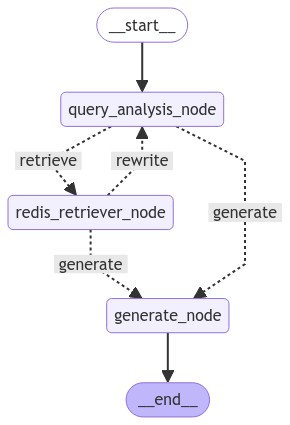

In [44]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("query_analysis_node", query_understanding_node)
workflow.add_node("redis_retriever_node", redis_retriever_node)
workflow.add_node("generate_node", generate_node)

# Decide whether to retrieve
workflow.add_conditional_edges(
    "redis_retriever_node",
    check_retrieval_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "rewrite": "query_analysis_node",
        "generate": "generate_node",
    },
)


workflow.add_conditional_edges(
    "query_analysis_node",
    check_question_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "retrieve": "redis_retriever_node",
        "generate": "generate_node",
    },
)


workflow.add_edge("generate_node", END)

workflow.set_entry_point("query_analysis_node")

# Compile
graphapp = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graphapp.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


In [45]:
inputs = {
    "question": "What was the deferred revenue of Apple in 2022?",
}

for output in graphapp.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


---QUERY Analysis---


score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


---QUERY rewrite---question_analysis=question_relevant=True question_class='10K' new_question='What is the deferred revenue reported by Apple in their 2022 annual report?' note="The question is relevant to the finance domain and can be answered by analyzing Apple's 10K filings. The rewritten question is more specific and accurate."
---Question is related to: 10K---
Output from node 'query_analysis_node':
---
{'filters': '@doc_type:{10K}', 'question_relevant': True, 'question_class': '10K', 'alternate_question': 'What is the deferred revenue reported by Apple in their 2022 annual report?', 'question_note': "The question is relevant to the finance domain and can be answered by analyzing Apple's 10K filings. The rewritten question is more specific and accurate.", 'rewrite_num': 1}

---


---RETRIEVE FROM REDIS---
---RETRIEVE FROM REDIS query=What was the deferred revenue of Apple in 2022? alternate_question=What is the deferred revenue reported by Apple in their 2022 annual report? retrie

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


---QUERY rewrite---question_analysis=question_relevant=True question_class='10K' new_question='What is the deferred revenue reported by Apple in their 2022 annual report?' note="The question is relevant to the finance domain and can be answered by analyzing Apple's 10K filings. The rewritten question is more specific and accurate."
---Question is related to: 10K---
Output from node 'query_analysis_node':
---
{'filters': '@doc_type:{10K}', 'question_relevant': True, 'question_class': '10K', 'alternate_question': 'What is the deferred revenue reported by Apple in their 2022 annual report?', 'question_note': "The question is relevant to the finance domain and can be answered by analyzing Apple's 10K filings. The rewritten question is more specific and accurate.", 'rewrite_num': 2}

---


---RETRIEVE FROM REDIS---
---RETRIEVE FROM REDIS query=What was the deferred revenue of Apple in 2022? alternate_question=What is the deferred revenue reported by Apple in their 2022 annual report? retrie

In [46]:
inputs2 = {
    "question": "Why colorless green ideas are furiously sleeping?"
}

for output2 in graphapp.stream(inputs2):
    for key2, value2 in output2.items():
        print(f"Output from node '{key2}':")
        print("---")
        print(value2)
    print("\n---\n")


---QUERY Analysis---
---QUERY rewrite---question_analysis=question_relevant=False question_class=None new_question=None note='The question appears to be a famous example of a sentence that is grammatically correct but semantically nonsensical, and is not relevant to the finance domain.'
Output from node 'query_analysis_node':
---
{'filters': '@doc_type:{10K}', 'question_relevant': False, 'question_class': None, 'alternate_question': None, 'question_note': 'The question appears to be a famous example of a sentence that is grammatically correct but semantically nonsensical, and is not relevant to the finance domain.', 'rewrite_num': 1}

---


---GENERATE---

DEBUG:GENERATE === question=Why colorless green ideas are furiously sleeping?
DEBUG:GENERATE === context=Your question does not seem to be relevant to finance. Please only ask questions that are relevant to financials of companies that are usually reported in 10K or earning calls.

The question appears to be a famous example of a se

## Next Steps

- Multiple index routing scenarios where based on the detected `question_class` we run retrieval queries on different Redis indices.
- Implement proper query decomposition and multi query retrieval.
- Test parent document retrieval in the context of agentic RAG.
- Implement a semantic caching strategy in Redis.